In [1]:
# from gorillatracker.args import TrainingArgs
import json
from pathlib import Path
from typing import Any, Callable, Dict, Literal, Tuple, Type, Union
from urllib.parse import urlparse

import cv2
import cv2.typing as cvt
import pandas as pd
import torch
import torchvision.transforms as transforms
import wandb
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm

from gorillatracker.model import BaseModule, get_model_cls
from gorillatracker.train_utils import get_dataset_class
from gorillatracker.type_helper import Label
from gorillatracker.scripts.create_dataset_from_videos import _crop_image

wandbRun = Any


def _get_frames_for_ids(json_path: str) -> Any:
    """Get the frames for the given IDs.

    Args:
        json_path: Path to the JSON file containing the IDs.

    Returns:
        Dictionary of IDs to frames.
    """
    id_frames: Any = {}
    face_class: int = 1
    # read the JSON file
    with open(json_path, "r") as f:
        data = json.load(f)
    for frame_idx, frame in enumerate(data["labels"]):
        for bbox in frame:
            if bbox["class"] != face_class:
                continue
            id = int(bbox["id"])
            if id not in id_frames:
                id_frames[id] = []
            id_frames[id].append((frame_idx, (bbox["center_x"], bbox["center_y"], bbox["w"], bbox["h"])))

    return id_frames


def get_wandb_api() -> wandb.Api:
    if not hasattr(get_wandb_api, "api"):
        get_wandb_api.api = wandb.Api()  # type: ignore
    return get_wandb_api.api  # type: ignore


def parse_wandb_url(url: str) -> Tuple[str, str, str]:
    assert url.startswith("https://wandb.ai/")
    parsed = urlparse(url)
    assert parsed.netloc == "wandb.ai"
    print(parsed, parsed.path.split("/"), parsed.path)
    parts = parsed.path.strip("/").split(
        "/"
    )  # ['gorillas', 'Embedding-SwinV2-CXL-Open', 'runs', 'fnyvl65k', 'overview']
    entity, project, s_runs, run_id, *rest = parts
    assert (
        s_runs == "runs"
    ), "expect: https://wandb.ai/gorillas/Embedding-SwinV2-CXL-Open/runs/fnyvl65k/overview like format."
    return entity, project, run_id


def get_run(url: str) -> wandbRun:
    # https://docs.wandb.ai/ref/python/run
    entity, project, run_id = parse_wandb_url(url)
    run = get_wandb_api().run(f"{entity}/{project}/{run_id}")  # type: ignore
    return run


def load_model_from_wandb(
    wandb_fullname: str, model_cls: Type[BaseModule], model_config: Dict[str, Any], device: str = "cpu"
) -> BaseModule:
    api = get_wandb_api()

    artifact = api.artifact(  # type: ignore
        wandb_fullname,
        type="model",
    )
    artifact_dir = artifact.download()
    model = artifact_dir + "/model.ckpt"  # all of our models are saved as model.ckpt
    checkpoint = torch.load(model, map_location=torch.device("cpu"))
    model_state_dict = checkpoint["state_dict"]

    model = model_cls(**model_config)

    if (
        "loss_module_train.prototypes" in model_state_dict or "loss_module_val.prototypes" in model_state_dict
    ):  # necessary because arcface loss also saves prototypes
        model.loss_module_train.prototypes = torch.nn.Parameter(model_state_dict["loss_module_train.prototypes"])
        model.loss_module_val.prototypes = torch.nn.Parameter(model_state_dict["loss_module_val.prototypes"])
    # note the following lines can fail if your model was not trained with the same 'embedding structure' as the current model class
    # easiest fix is to just use the old embedding structure in the model class
    model.load_state_dict(model_state_dict)

    model.to(device)
    model.eval()
    return model


def generate_embeddings(model: BaseModule, dataset: Any, device: str = "cpu") -> pd.DataFrame:
    embeddings = []
    df = pd.DataFrame(columns=["embedding", "label", "input", "label_string"])
    with torch.no_grad():
        print("Generating embeddings...")
        for imgs, labels in tqdm(dataset):
            if isinstance(imgs, torch.Tensor):
                imgs = [imgs]
                labels = [labels]
            batch_inputs = torch.stack(imgs)
            if batch_inputs.shape[0] != 1:
                batch_inputs = batch_inputs.unsqueeze(1)
            batch_inputs = batch_inputs.to(device)
            embeddings = model(batch_inputs)

            for i in range(len(imgs)):
                input_img = transforms.ToPILImage()(batch_inputs[i].cpu())
                df = pd.concat(
                    [
                        df,
                        pd.DataFrame(
                            {
                                "embedding": [embeddings[i]],
                                "label": [labels[i]],
                                "input": [input_img],
                                "label_string": [dataset.mapping[labels[i]]] if dataset.mapping else None,
                            }
                        ),
                    ]
                )
    df.reset_index(drop=False, inplace=True)
    return df


def get_dataset(
    model: BaseModule,
    partition: Literal["train", "val", "test"],
    data_dir: str,
    dataset_class: str,
    transform: Union[Callable[..., Any], None] = None,
) -> Dataset[Tuple[Any, Label]]:
    cls = get_dataset_class(dataset_class)
    if transform is None:
        transform = transforms.Compose(
            [
                cls.get_transforms(),  # type: ignore
                model.get_tensor_transforms(),
            ]
        )

    return cls(  # type: ignore
        data_dir=data_dir,
        partition=partition,
        transform=transform,
    )


def get_latest_model_checkpoint(run: wandbRun) -> wandb.Artifact:
    models = [a for a in run.logged_artifacts() if a.type == "model"]
    return max(models, key=lambda a: a.created_at)


def generate_embeddings_from_run(run_url: str, outpath: str) -> pd.DataFrame:
    """
    generate a pandas df that generates embeddings for all images in the dataset partitions train and val.
    stores to DataFrame
    partition, image_path, embedding, label, label_string
    """
    out = Path(outpath)
    is_write = outpath != "-"
    if is_write:
        assert not out.exists(), "outpath must not exist"
        assert out.parent.exists(), "outpath parent must exist"
        assert out.suffix == ".pkl", "outpath must be a pickle file"

    run = get_run(run_url)
    print("Using model from run:", run.name)
    print("Config:", run.config)
    # args = TrainingArgs(**run.config) # NOTE(liamvdv): contains potenially unknown keys / missing keys (e. g. l2_beta)
    args = {
        k: run.config[k]
        for k in (
            # Others:
            "model_name_or_path",
            "dataset_class",
            "data_dir",
            # Model Params:
            "embedding_size",
            "from_scratch",
            "loss_mode",
            "weight_decay",
            "lr_schedule",
            "warmup_mode",
            "warmup_epochs",
            "max_epochs",
            "initial_lr",
            "start_lr",
            "end_lr",
            "beta1",
            "beta2",
            # NOTE(liamvdv): might need be extended by other keys if model keys change
        )
    }

    print("Loading model from latest checkpoint")
    model_path = get_latest_model_checkpoint(run).qualified_name
    model_cls = get_model_cls(args["model_name_or_path"])
    model = load_model_from_wandb(model_path, model_cls=model_cls, model_config=args)

    train_dataset = get_dataset(
        partition="train", data_dir=args["data_dir"], model=model, dataset_class=args["dataset_class"]
    )
    val_dataset = get_dataset(
        partition="val", data_dir=args["data_dir"], model=model, dataset_class=args["dataset_class"]
    )

    val_df = generate_embeddings(model, val_dataset)
    val_df["partition"] = "val"

    train_df = generate_embeddings(model, train_dataset)
    train_df["partition"] = "train"

    df = pd.concat([train_df, val_df], ignore_index=True)

    print("Embeddings for", len(df), "images generated")

    # store
    if is_write:
        df.to_pickle(outpath)
    print("done")
    return df


def generate_embeddings_from_tracked_video(
    model: BaseModule, video_path: str, tracking_data, model_transforms=lambda x: x
) -> pd.DataFrame:  # TODO
    """
    Args:
        model: The model to use for embedding generation.
        video_path: Path to the video.
        tracking_data: Dictionary of Individual IDs to frames. -> {id: List[(frame_idx, (bbox))]} (bbox = (x, y, w, h)

    Returns:
        DataFrame with columns: invididual_id, frame_id, bbox, embedding,
    """
    min_frames = 15  # discard if less than 5 images
    max_per_individual = 15

    tracking_data = {
        id: frames for id, frames in tracking_data.items() if len(frames) >= min_frames
    }  # discard if less than 5 images
    print("Using", len(tracking_data), "individuals")

    video = cv2.VideoCapture(video_path)
    embedding_img_table = pd.DataFrame(columns=["embedding", "frame_id", "bbox", "invididual_id"])

    for id, frames in tracking_data.items():
        step_size = len(frames) // max_per_individual
        if step_size == 0:
            continue
        frame_list = [frames[i] for i in range(0, max_per_individual * step_size, step_size)]
        for frame_idx, bbox in frame_list:
            video.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            frame = video.read()[1]  # read the frame. read() returns a tuple of (success, frame)
            embedding = get_embedding_from_frame(model, frame, bbox, model_transforms)
            embedding_img_table = pd.concat(
                [
                    embedding_img_table,
                    pd.DataFrame(
                        {
                            "invididual_id": [id],
                            "frame_id": [frame_idx],
                            "bbox": [bbox],
                            "embedding": [embedding],
                        }
                    ),
                ],
                ignore_index=True,
            )
    video.release()
    embedding_img_table.reset_index(drop=False, inplace=True)
    return embedding_img_table


@torch.no_grad()
def get_embedding_from_frame(model: BaseModule, frame: cvt.MatLike, bbox, model_transforms) -> torch.Tensor:  # TODO
    frame_cropped = _crop_image(
        frame,
        bbox[0],  # x
        bbox[1],  # y
        bbox[2],  # w
        bbox[3],  # h
    )

    # convert to pil image
    img = cv2.cvtColor(frame_cropped, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    img = model_transforms(img)

    model.eval()
    embedding = model(img.unsqueeze(0))
    return embedding


def read_embeddings_from_disk(path: str) -> pd.DataFrame:
    return pd.read_pickle(path)

## Code used for loading in another notebook

In [4]:
from gorillatracker.model import EfficientNetV2Wrapper
from gorillatracker.transform_utils import SquarePad
from torchvision.transforms import v2 as transforms_v2

model_config = {
    "embedding_size": 64,
    "from_scratch": False,
    "loss_mode": "softmax/arcface",
    "weight_decay": 0.0005,
    "lr_schedule": "cosine",
    "warmup_mode": "linear",
    "warmup_epochs": 10,
    "max_epochs": 100,
    "initial_lr": 0.01,
    "start_lr": 0.01,
    "end_lr": 0.0001,
    "beta1": 0.9,
    "beta2": 0.999,
    "model_name_or_path": "SwinV2LargeWrapper",
    "stepwise_schedule": True,
    "lr_interval": 10,
    "l2_beta": 0.0,
    "l2_alpha": 0.0,
    "path_to_pretrained_weights": "a/b/c",
}
model = load_model_from_wandb(
    "gorillas/Dante-Sweep-Embedding-Size/model-z152og1r:v2", EfficientNetV2Wrapper, model_config, "cpu"
)
model.eval()
model_transforms = transforms.Compose(
    [
        SquarePad(),
        # Uniform input, you may choose higher/lower sizes.
        transforms.ToTensor(),
        transforms_v2.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Resize((224, 224)),
    ]
)
video_path = "/workspaces/gorillatracker/video_data/M002_20220725_006.mp4"
tracked_video_path = (
    "/workspaces/gorillatracker/data/derived_data/spac_gorillas_converted_labels_tracked/M002_20220725_006_tracked.json"
)
tracked_video = _get_frames_for_ids(tracked_video_path)
embedding_img_table = generate_embeddings_from_tracked_video(model, video_path, tracked_video, model_transforms)

wandb: Downloading large artifact model-z152og1r:v2, 1345.89MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.8


Using 7 individuals


In [5]:
embedding_img_table.loc[0, "embedding"].shape

torch.Size([1, 64])

(105, 64)


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

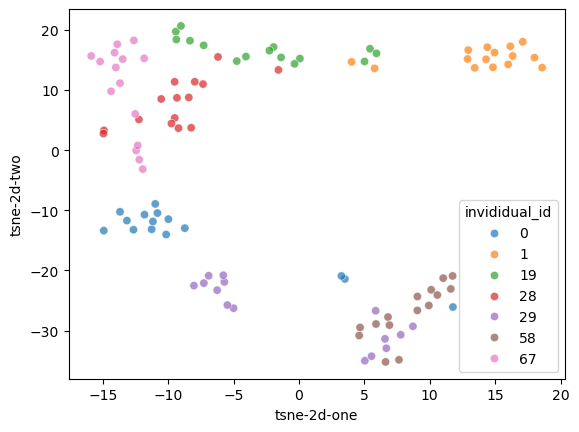

In [6]:
# plot embeddings using t-SNE use one color for each individual_id

from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
X = torch.stack(embedding_img_table.embedding.to_list()).numpy().reshape(-1, 64)
print(X.shape)
X_2d = tsne.fit_transform(X)

embedding_img_table["tsne-2d-one"] = X_2d[:, 0]
embedding_img_table["tsne-2d-two"] = X_2d[:, 1]

sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="invididual_id",
    palette=sns.color_palette("tab10", len(embedding_img_table.invididual_id.unique())),
    data=embedding_img_table,
    legend="full",
    alpha=0.7,
)

In [7]:
from gorillatracker.datasets.cxl import CXLDataset

# generate table that contains labels and images and embeddings
df = pd.DataFrame(columns=["label", "image", "embedding"])
dataset = CXLDataset(
    data_dir="/workspaces/gorillatracker/data/splits/ground_truth-cxl-face_images-openset-reid-val-0-test-0-mintraincount-3-seed-42-train-50-val-25-test-25",
    partition="val",
    transform=transforms.Compose(  # use the transforms that were used for the model (except of course data augmentations)
        [
            SquarePad(),
            # Uniform input, you may choose higher/lower sizes.
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
        ]
    ),
)

for i in range(len(dataset)):
    image_tensor, label = dataset[i]
    label_string = dataset.mapping[label]
    image = transforms.ToPILImage()(image_tensor)
    image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.228, 0.224, 0.225])(
        image_tensor
    )  # if your model was trained with normalization, you need to normalize the images here as well
    embedding = model(image_tensor.unsqueeze(0))
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                {
                    "label_string": [label_string],
                    "label": [label],
                    "image": [image],
                    "embedding": [embedding[0].detach().numpy()],
                }
            ),
        ]
    )

    if i % 10 == 0:
        print(f"\rprocessed {i} images")
df = df.reset_index(drop=False)

processed 0 images


processed 10 images
processed 20 images
processed 30 images
processed 40 images
processed 50 images
processed 60 images
processed 70 images
processed 80 images
processed 90 images
processed 100 images
processed 110 images
processed 120 images


(126, 64)


(126, 2)


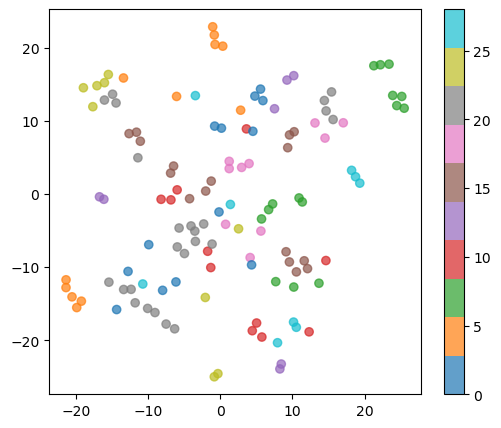

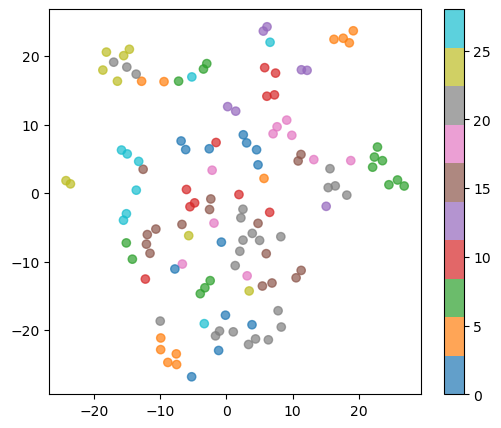

In [8]:
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
X1 = np.stack(df.embedding.to_list()).reshape(-1, 64)
X2 = np.stack(df.embedding.apply(lambda x: x + 2.0).apply(lambda x: x.astype(np.int8)).to_list()).reshape(-1, 64)
print(X1.shape)
X_2d1 = tsne.fit_transform(X1)
X_2d2 = tsne.fit_transform(X2)
print(X_2d1.shape)

# plot embeddings using plt scatter
plt.figure(figsize=(6, 5))
plt.scatter(X_2d1[:, 0], X_2d1[:, 1], c=df.label, cmap="tab10", alpha=0.7)
plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(X_2d2[:, 0], X_2d2[:, 1], c=df.label, cmap="tab10", alpha=0.7)
plt.colorbar()
plt.show()

In [87]:
from gorillatracker.metrics import knn_naive
from tqdm import tqdm

# cast the embeddings to float16 to save memory
# print(df.embedding[0])
# embeddings_list = df.embedding.apply(lambda x: (x + 2.0).astype(np.uint8))
# print(embeddings_list[0])

# train a lin layer for quantization
linLayer = torch.nn.Linear(64, 64)
# linLayer.weight.data = torch.eye(64)
# torch.nn.init.xavier_uniform_(linLayer.weight)
# linLayer.bias.data = torch.zeros(64) + 2.0


def heaviside_approx(x):
    return 0.5 + torch.tanh(x * 20) * 0.5


def multi_step(y, lower_bound=-127, upper_bound=127):
    y = y.view(-1, 1)
    values = torch.tensor([x + 0.5 for x in range(lower_bound, upper_bound)]).view(1, -1)
    y_broad = y - values
    y_broad = y_broad.clamp(lower_bound, upper_bound)
    return heaviside_approx(y_broad).sum(dim=1) + lower_bound


torch.manual_seed(42)


def objective(x, y):
    return ((abs(x - multi_step(y))) ** 2).mean()

100%|██████████| 100/100 [00:06<00:00, 14.54it/s]


{'accuracy': 0.0396825410425663, 'accuracy_top5': 0.2222222238779068, 'auroc': 0.49189290404319763, 'f1': 0.03211233392357826}
{'accuracy': 0.0476190522313118, 'accuracy_top5': 0.1746031790971756, 'auroc': 0.481122761964798, 'f1': 0.03988604247570038}
{'accuracy': 0.055555559694767, 'accuracy_top5': 0.230158731341362, 'auroc': 0.4884300231933594, 'f1': 0.03994709253311157}


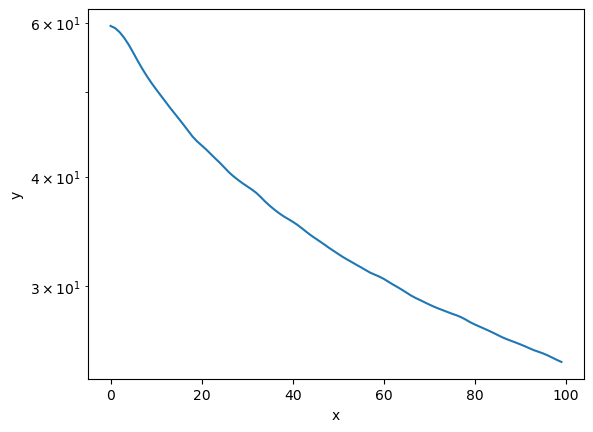

In [88]:
epochs = 100
weight_decay = 0.001
losses = []
accuracies = []
np.random.seed(42)
embeddings_torch = torch.tensor(np.stack(df.embedding.to_list()).reshape(-1, 64), dtype=torch.float32)
optimizer = torch.optim.SGD(linLayer.parameters(), lr=0.01, momentum=0.9)

for i in tqdm(range(epochs)):
    loss = torch.tensor(0.0)

    embeddings_torch = embeddings_torch.numpy()
    np.random.shuffle(embeddings_torch)
    embeddings_torch = torch.tensor(embeddings_torch, dtype=torch.float32)
    for i in range(len(df)):
        x = embeddings_torch[i]
        y = linLayer(x)
        loss += objective(x, y)
    loss += weight_decay * torch.norm(linLayer.weight, p=2)
    losses.append(loss.item())
    loss.backward()
    torch.nn.utils.clip_grad_norm_(linLayer.parameters(), 1.0)
    optimizer.step()
    embeddings_quantized = linLayer(embeddings_torch).detach().numpy()
    embeddings_quantized = [np.round(x) for x in embeddings_quantized]
    results = knn_naive(embeddings_quantized, df.label.to_list(), k=5)
    accuracies.append(results["accuracy"])
    optimizer.zero_grad()

embeddings_quantized = linLayer(embeddings_torch).detach().numpy()
embeddings_quantized = [np.round(x) for x in embeddings_quantized]
results = knn_naive(embeddings_quantized, df.label.to_list(), k=1)
print(results)
results = knn_naive(embeddings_quantized, df.label.to_list(), k=3)
print(results)
results = knn_naive(embeddings_quantized, df.label.to_list(), k=5)
print(results)


plt.figure()
plt.semilogy(losses)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

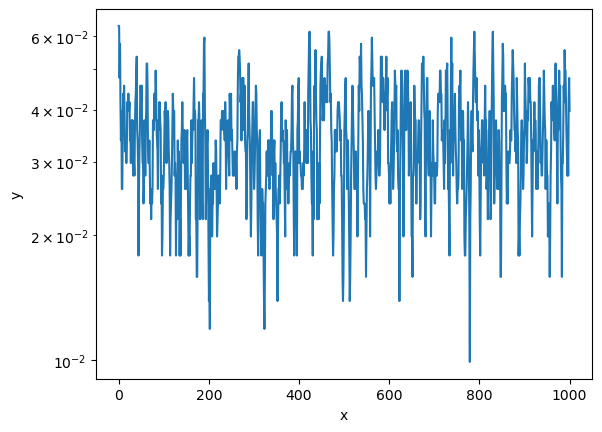

In [83]:
# plot the loss
# calculate a running average
running_average = []
pace = 2
for i in range(epochs):
    lower = max(0, i - pace)
    upper = min(epochs + 1, i + pace)
    amount = upper - lower
    running_average.append(sum(accuracies[lower:upper]) / amount)


x = np.linspace(0, epochs, epochs)
plt.figure()
# plt.semilogy(x, losses)
plt.semilogy(x, running_average)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

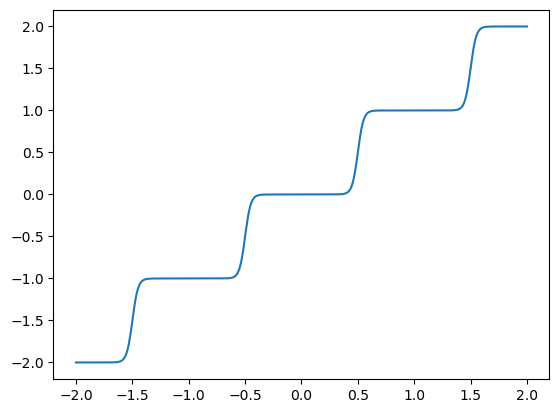

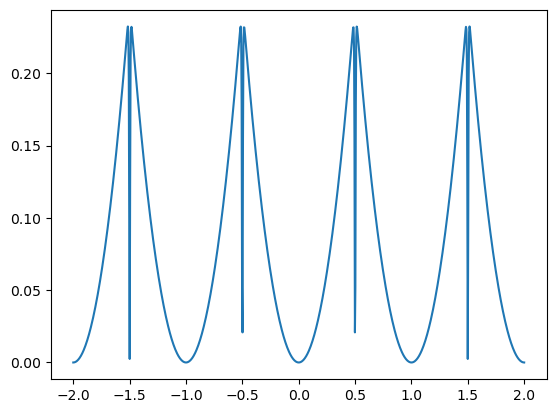

In [85]:
# plot objective function for scalar input between -5 and 5
def func(y, lower_bound=-127, upper_bound=127):
    y = torch.tensor([y])
    y = y.view(-1, 1)
    values = torch.tensor([x + 0.5 for x in range(lower_bound, upper_bound)]).view(1, -1)
    y_broad = y - values
    y_broad = y_broad.clamp(lower_bound, upper_bound)
    return heaviside_approx(y_broad).sum(dim=1) + lower_bound


def objective_scalar(y):
    return (y - func(y)) ** 2


x = np.linspace(-2, 2, 1000)
y1 = [func(x_i) for x_i in x]
y2 = [objective(torch.tensor(x_i), func(x_i)) for x_i in x]

plt.figure()
plt.plot(x, y1)
plt.show()

plt.figure()
plt.plot(x, y2)
plt.show()

In [41]:
from gorillatracker.metrics import knn_naive

embeddings_transformed = df.embedding.apply(lambda x: (x + 2.0).astype(np.int8)).to_list()
results = knn_naive(embeddings_transformed, df.label.to_list(), k=1)
print(results)

{'accuracy': 0.6666666865348816, 'accuracy_top5': 0.6984127163887024, 'auroc': 0.7805317640304565, 'f1': 0.6048352122306824}


In [79]:
# get all embeddings for label[0]
index = 0
sums = 0
for i, label in enumerate(df.label.to_list()):
    if label == df.label[index]:
        sums += ((embeddings_list[i] - embeddings_list[index]) ** 2).sum()
# print(sums / (len(df.label.to_list()) - 3))
print(sums / 2)

28.5


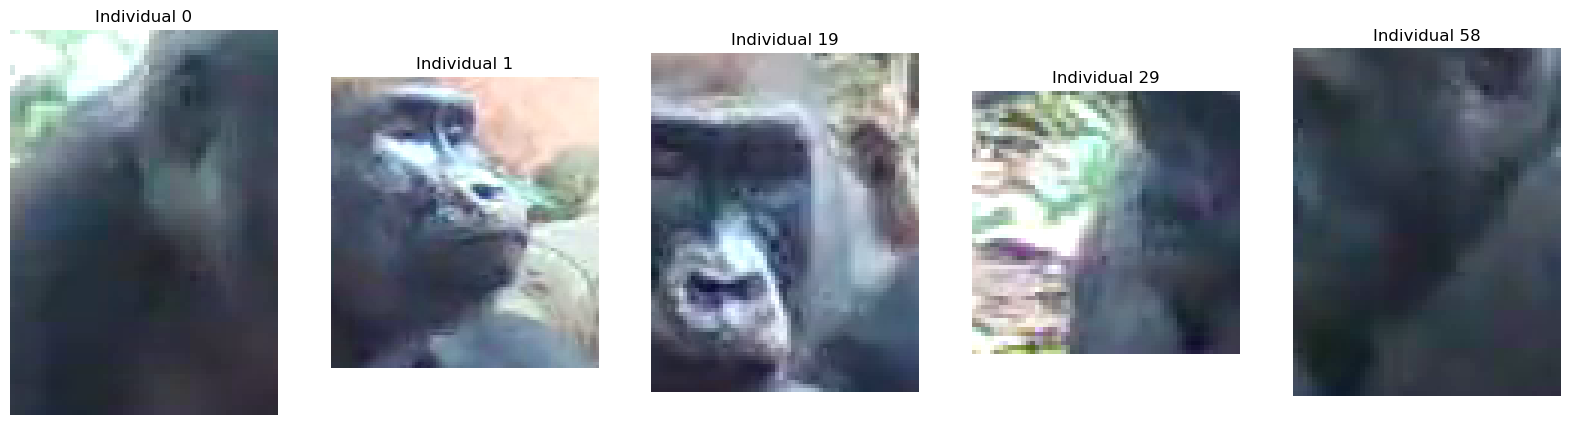

In [82]:
# plot a frame for each individual_id

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(embedding_img_table.invididual_id.unique()), figsize=(20, 10))
for i, id in enumerate(embedding_img_table.invididual_id.unique()):
    img = embedding_img_table[embedding_img_table.invididual_id == id].iloc[10].frame_id
    bbox = embedding_img_table[embedding_img_table.invididual_id == id].iloc[0].bbox
    # get the frame from the video
    video = cv2.VideoCapture(video_path)
    video.set(cv2.CAP_PROP_POS_FRAMES, img)
    img = video.read()[1]
    img = _crop_image(img, bbox[0], bbox[1], bbox[2], bbox[3])
    video.release()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    # crop image
    ax[i].imshow(img)
    ax[i].set_title(f"Individual {id}")
    ax[i].axis("off")

plt.show()

In [79]:
# merge individual 19 20 and 67

embedding_img_table["invididual_id"] = embedding_img_table["invididual_id"].replace({28: 19})
embedding_img_table["invididual_id"] = embedding_img_table["invididual_id"].replace({67: 19})